In [65]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import seaborn
import re
import matplotlib.pyplot as plt
import seaborn as sns

print("All packages installed successfully!")



All packages installed successfully!


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
)

In [67]:
reddit_df = pd.read_csv("depression_dataset_reddit_cleaned.csv")
twitter_df = pd.read_csv("Twitter_Data.csv")


✅ Combined dataset size: (170700, 2)
label
 1.0    76080
 0.0    59111
-1.0    35509
Name: count, dtype: int64

🧹 After label normalization:
label
not_depressed    94620
depressed        76080
Name: count, dtype: int64

📊 Logistic Regression Classification Report:

               precision    recall  f1-score   support

    depressed       0.91      0.80      0.85     15216
not_depressed       0.85      0.93      0.89     18924

     accuracy                           0.87     34140
    macro avg       0.88      0.87      0.87     34140
 weighted avg       0.88      0.87      0.87     34140


📊 Decision Tree Classification Report:

               precision    recall  f1-score   support

    depressed       0.91      0.33      0.48     15216
not_depressed       0.64      0.97      0.77     18924

     accuracy                           0.69     34140
    macro avg       0.77      0.65      0.63     34140
 weighted avg       0.76      0.69      0.64     34140


📊 KNN Classification Repor

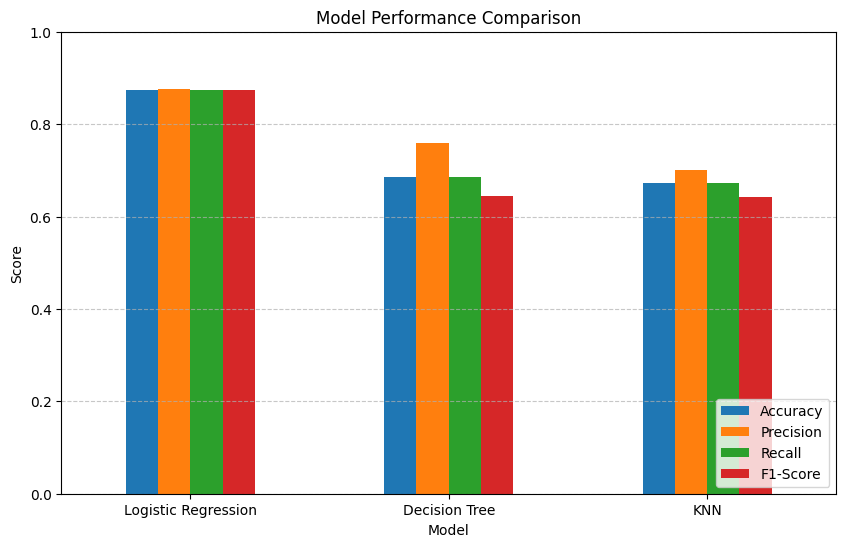

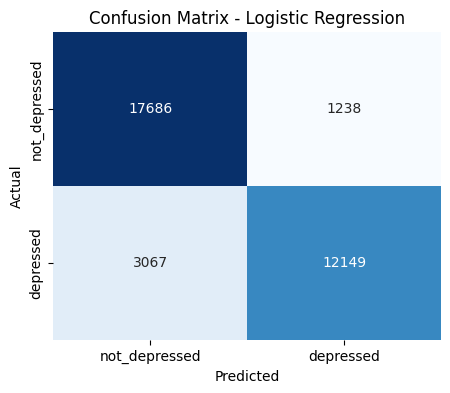

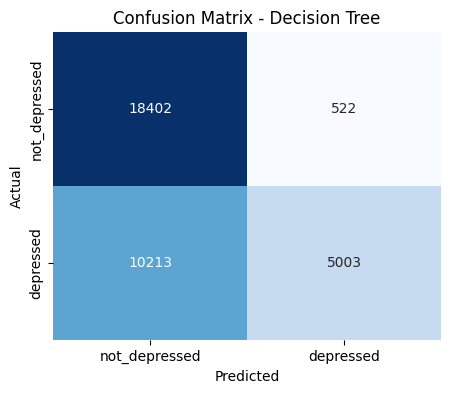

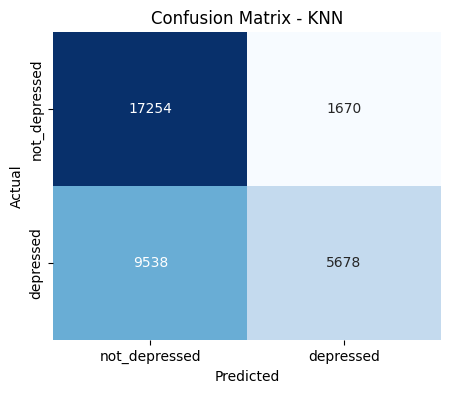

In [68]:
reddit_df = reddit_df[['clean_text', 'is_depression']]
twitter_df = twitter_df[['clean_text', 'category']]

reddit_df.rename(columns={'clean_text': 'text', 'is_depression': 'label'}, inplace=True)
twitter_df.rename(columns={'clean_text': 'text', 'category': 'label'}, inplace=True)

# 4️⃣ Combine datasets
combined_df = pd.concat([reddit_df, twitter_df], ignore_index=True)
combined_df.dropna(subset=['text', 'label'], inplace=True)
print("✅ Combined dataset size:", combined_df.shape)
print(combined_df['label'].value_counts())

# 5️⃣ Normalize labels → only 'depressed' / 'not_depressed'
def normalize_label(x):
    try:
        x = str(x).strip().lower()
        if x in ['1', '1.0', 'depression', 'depressed', 'yes', 'true']:
            return 'depressed'
        elif x in ['-1', '-1.0', '0', '0.0', 'no', 'false', 'not depressed', 'neutral']:
            return 'not_depressed'
        else:
            return np.nan
    except:
        return np.nan

combined_df['label'] = combined_df['label'].apply(normalize_label)
combined_df.dropna(subset=['label'], inplace=True)
print("\n🧹 After label normalization:")
print(combined_df['label'].value_counts())

# 6️⃣ Text cleaning
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

combined_df['text'] = combined_df['text'].apply(clean_text)

# 7️⃣ Split data
X = combined_df['text']
y = combined_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 8️⃣ TF-IDF vectorization (improved)
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 9️⃣ Train models
# Logistic Regression (strong baseline)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)

# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train_tfidf, y_train)
dt_pred = dt_model.predict(X_test_tfidf)

# KNN
knn_model = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_model.fit(X_train_tfidf, y_train)
knn_pred = knn_model.predict(X_test_tfidf)

# 🔟 Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n📊 {model_name} Classification Report:\n")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    return acc, prec, rec, f1

lr_acc, lr_prec, lr_rec, lr_f1 = evaluate_model(y_test, lr_pred, "Logistic Regression")
dt_acc, dt_prec, dt_rec, dt_f1 = evaluate_model(y_test, dt_pred, "Decision Tree")
knn_acc, knn_prec, knn_rec, knn_f1 = evaluate_model(y_test, knn_pred, "KNN")

# 11️⃣ Compare performance
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'KNN'],
    'Accuracy': [lr_acc, dt_acc, knn_acc],
    'Precision': [lr_prec, dt_prec, knn_prec],
    'Recall': [lr_rec, dt_rec, knn_rec],
    'F1-Score': [lr_f1, dt_f1, knn_f1]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 12️⃣ Confusion Matrix plot
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['not_depressed','depressed'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['not_depressed','depressed'],
                yticklabels=['not_depressed','depressed'])
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_conf_matrix(y_test, lr_pred, "Logistic Regression")
plot_conf_matrix(y_test, dt_pred, "Decision Tree")
plot_conf_matrix(y_test, knn_pred, "KNN")